# Basic time series analysis
Note: I'm no expert; here are resources I'm using:
- [Analyticsvidhya tutorial](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)  Not very good; very heuristic
- [Connor Johnson tutorial](http://connor-johnson.com/2014/11/23/time-series-forecasting-in-python-and-r/)
- [Machine Learning Mastery tutorial](http://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
- [Tom Augspurger tutorial](https://tomaugspurger.github.io/modern-7-timeseries.html) Finally, these are the droids we're looking for.

Steps to doing basic time series analysis:
- Want a *stationary* process:
 - Constant mean
 - Constant variance
 - Otherwise, error term will accumulate
- Make dataset stationary:
 - Remove trend (general slope)
 - Remove cyclicality (long-period cycles)
 - Remove seasonality (short-period cycles)
 - Remainder: residual stationary process

- Check stationarity
 - 
 - Plot rolling statistics (moving average, moving variance) and look for constant value
 - Dickey-fuller test: test whether it is significantly different from a non-stationary time series
 - Check whether roots of the characteristic equation of the auto-regressive process are outside the unit circle
  
Covariance: $\text{cov}(X,Y) = E[(X-E[X]) (Y - E[Y])]$   

Autocovariance: determines how $y$ is related to its previous values. Computationally, $\gamma_s = E[\, (y_t - E[y_t])(y_{t-s} - E[y_{t-s}])\,] \;, \, s=0,1,2,\ldots$ 
- i.e. the autocovariance at $s=0$ is just the variance. When $s>0$ we are measuring the covariance of the variable with its predecessors at lag $s$

Autocorrelation: Scale the autocovariances by the variance, i.e. $\tau_s = \frac{\gamma_s}{\gamma_0}, s=0,1,2,\ldots$
 - Because these are normalized, they will always be between -1 and 1 (positive or negative indicating the relationship at that lag)
 - Plotting the autocorrelation against the lag gives the *autocorrelation function* (acf) or 'correlogram'
 
If $y_t$ is distributed normally, then the sample autocorrelation coefficients will also be normally distributed, with $\tau_s \sim N(0,1/T)$
- This is the difference between the theoretical distribution of coefficients (where autocorrelations at s>0 will be 0) and real data.
- Because of this, we want to figure out whether the observed autocorrelations are *actually* significant, or whether they are actually just a remnant of white noise with a small sample size.
- This lets us construct a region of confidence within which we can assume that the remainder is white noise- these are the dotted lines in the autocorrelation function plot.
- Our data are significantly not white-noise processes for even very large lags

Partial autocorrelation: correlation between current and the lagged observation, *after controlling for the intermediate lags*
- For an autoregressive process of order p, 

Moving Average processes:
- Weights on the averages of each of the *n* previous samples
- Typically described by the parameter *q*, being the maximum number of periods which are considered

Autoregressive process:
- Weights on the individual observations of the previous samples- not the averages!
- Described by parameter *p* the maximum number of periods considered
- Assessed using the PACF: the partial autocorrelation will be significant up to order *p* after which it will no longer be significant.

ARMA model:
- Combines AR(p) and MA(q) models.  Current value depends on its previous values, plus the values of the error term. 
$$
\begin{align}
\phi(L)y_t &= \mu + \theta(L)u_t \\
\phi(L) &= 1 - \phi_1 L - \phi_2 L^2 - \ldots - \phi_p L^p \\
\theta(L) &= 1 + \theta_1 L - \theta_2 L^2 - \ldots - \theta_q L^q 
\end{align}
$$

ACF can distinguish between a pure moving average process (zero lag after *q*) and pure autoregressive process (absolute value of acf decreases geometrically to zero).  However, an ARMA process can also have a geometrically declining ACF.  The PACF for an AR will drop to 0 after *p* lags, whereas the PACF for an ARMA process will decline geometrically.  Summary:
- Autoregressive:
 - Geometrically decaying bounds on ACF (specifically absolute value of ACF)
 - PACF drops to zero after *p* points
- Moving Average:
 - ACF is zero after *q* points
 - PACF decays geometrically
- ARMA process:
 - Geometrically decaying ACF
 - Geometrically decaying PCF
- Non-stationary process:
 - No geometric decay in ACF
 
Building ARMA models- Box-Jenkins Approach:
- Identification: Use ACF and PACF to identify the order of the model required
- Estimation: Estimate parameters for the model using OLS or MLE
- Model Checking: Overfitting (does adding additional terms not produce significant improvements?) and residual diagnostics (check residuals for linear dependence, which indicates that there are uncaptured terms). This is more common.

ARIMA: has an inherent markov process; this can be removed by differencing with degree *d* (i.e. ARIMA is controlled by variables *p,d,q*)

In [1]:
import pandas as pd
import numpy  as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
% matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys, os, copy
print("Using environment in "+sys.prefix)
print("Python version "+sys.version)

/Users/emunsing/Documents/Coding/github/cdips_hpi_forecast/env/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Using environment in /Users/emunsing/Documents/Coding/github/cdips_hpi_forecast/env
Python version 3.5.2 (default, Oct 31 2016, 16:50:28) 
[GCC 4.2.1 Compatible Apple LLVM 7.3.0 (clang-703.0.31)]


In [2]:
fname = 'Metro_Zhvi_AllHomes.csv'

#  Map Zillow RegionID to metro area string
metroRegionID = {'Dallas-Fort Worth, TX':394514,
                     'Atlanta, GA':394347,
                     'Phoenix, AZ':394976,
                     'Las Vegas, NV':394775 }

metroString = {'Dallas':u'Dallas-Fort Worth, TX',
               'Atlanta':u'Atlanta, GA',
               'Phoenix':u'Phoenix, AZ',
               'Vegas':u'Las Vegas, NV'}

city = 'Atlanta'
startDate = None #'2003-01'
endDate = None

df = pd.read_csv('Data/ZHVI/'+fname,index_col=[1])
df = df.drop(['RegionID','SizeRank'],axis=1)
df.columns = pd.DatetimeIndex(df.columns)
ts = df.loc[metroString[city], startDate:endDate ]

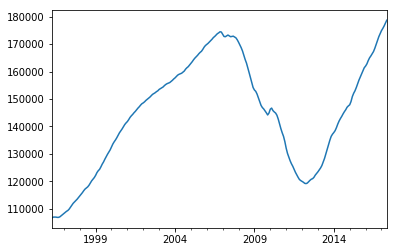

In [4]:
ts.plot()

In [ ]:
# By visual inspection, it appears to have been 193 months between 
#  the dip at the beginning of the data and the bottom of the recession.
# This is consistent with academic studies which have identified housing cycles every ~16-18 years.

[  1.43126686e+05   1.33860432e+02]


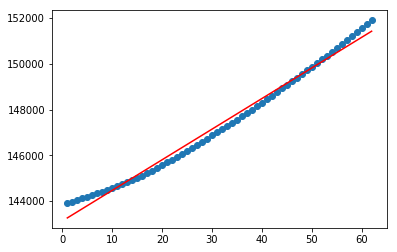

In [24]:
rollMean = pd.rolling_mean(ts,window=193)
y = rollMean.dropna().values
x = np.arange(1,len(y)+1)

Xm = sm.add_constant(x)
model = sm.OLS(y,Xm)
results = model.fit()
print(results.params)
temp = results.params[0]+x*results.params[1]
plt.plot(x,temp,'r')

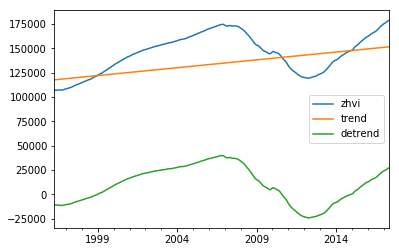

In [60]:
xtemp = np.arange(0,-1*ts.shape[0],-1)
xtemp = np.flipud(xtemp)
trend = xtemp*results.params[1] + temp[-1]

newDf = pd.DataFrame()
newDf['zhvi'] = ts
newDf['trend'] = trend
newDf['detrend'] = newDf['zhvi'] - newDf['trend']
newDf.plot()

In [85]:
tempDf = pd.DataFrame()

for k in np.arange(10,101,10):
    tempDf[k] = sm.tsa.filters.bkfilter(newDf['detrend'], low=50, high=200, K=k)

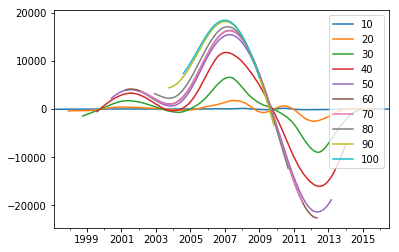

In [86]:
tempDf.plot()

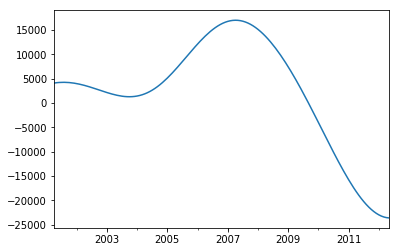

In [66]:
temp.plot()

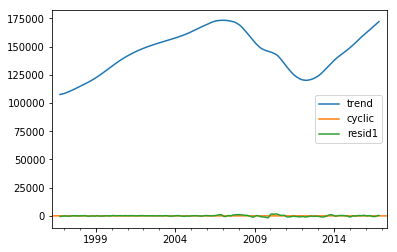

In [63]:
## Off-the-shelf seasonal decomposition: This does not seem effective!
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts)

components = pd.DataFrame()
components['trend']  = decomposition.trend
components['cyclic'] = decomposition.seasonal
components['resid1'] = decomposition.resid

components.plot()

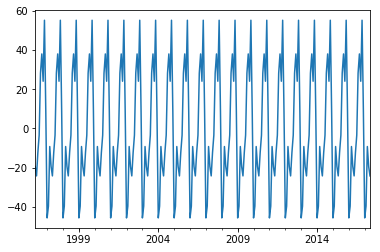

In [123]:
decomposition.seasonal.plot()

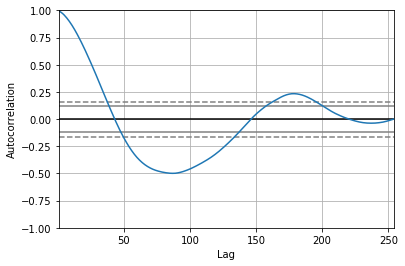

In [58]:
pd.tools.plotting.autocorrelation_plot(newDf['detrend'])
# Our data are still very significantly not white noise processes for large values- 
#  only becoming potentially white noise after a lag of ~190

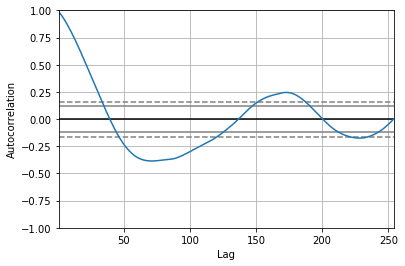

In [109]:
pd.tools.plotting.autocorrelation_plot(ts)

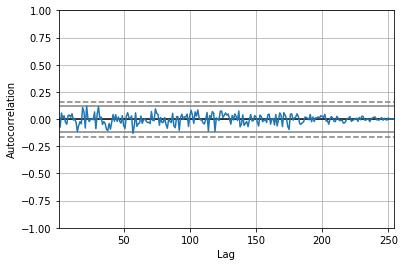

In [118]:
x = np.random.randn(ts.shape[0])
pd.tools.plotting.autocorrelation_plot(x)

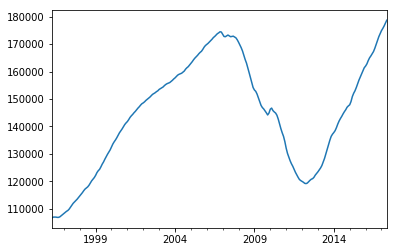

In [87]:
ts.plot()

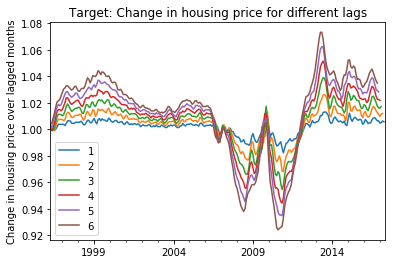

In [108]:
## Plot the target series for different target lags
cols = np.arange(1,7)
temp = pd.DataFrame(index=ts.index,columns = cols)

for i in range(1,7):
    tshift = ts[i:].values / ts[0:-i].values
    temp.iloc[0:-i,i-1] = tshift   

temp.plot()
plt.title('Target: Change in housing price for different lags')
plt.ylabel('Change in housing price over lagged months')


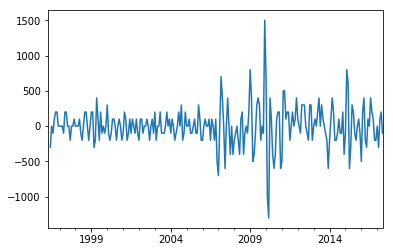

In [120]:
ts.diff().diff().plot()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,8))



allCitiesNormed[city].plot(colormap=cm.rainbow, ax=axes[row,col],title=city,legend=None)

In [129]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import seaborn as sns

In [130]:
def tsplot(y, lags=None, figsize=(10, 8)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(1.5) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

(<matplotlib.axes._subplots.AxesSubplot at 0x109349da0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10d885898>)

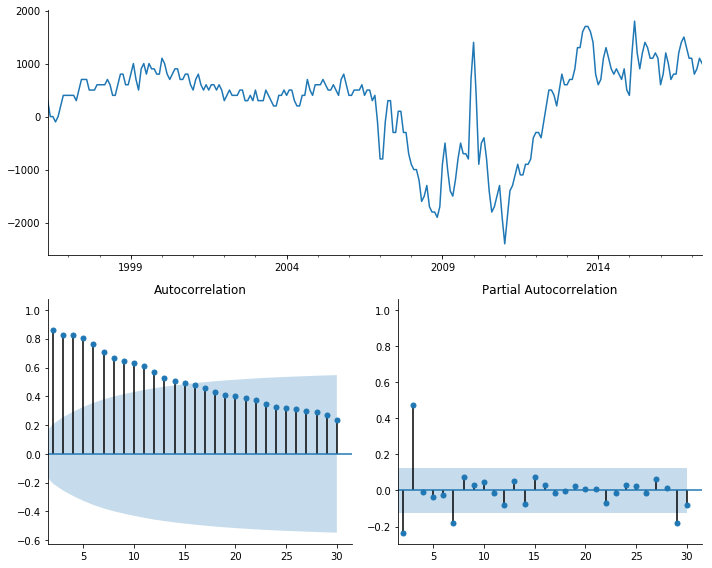

In [139]:
tsplot(ts.diff().dropna(),lags=30)

(<matplotlib.axes._subplots.AxesSubplot at 0x10e2cb748>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10e565940>)

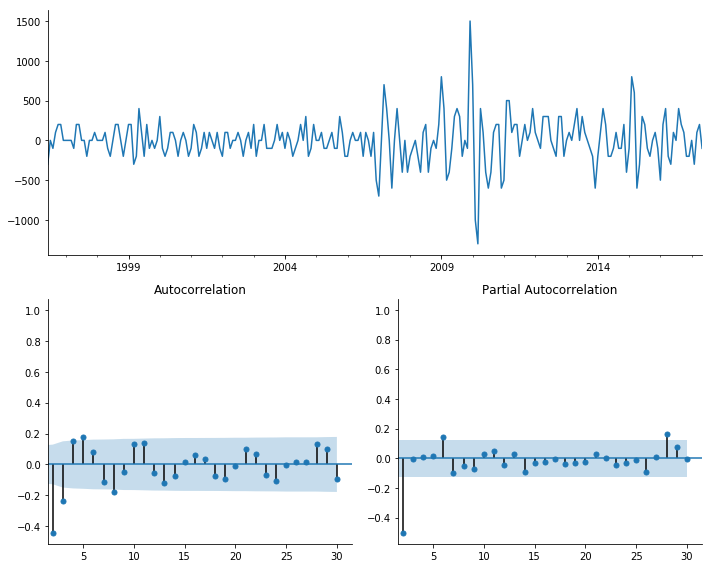

In [141]:
tsplot(ts.diff().dropna().diff().dropna(),lags=30)

So if I had to guess, I would say that there are seasonal effects at 8 months and 30 months that appear to be significant. A d=2 model seems to be necessary, as the single diff still has significant non-stationarity. 

For the double-diff model, it seems like q(MA) = 5 might be appropriate, and p(AR)=1.  Need to look into this, though...

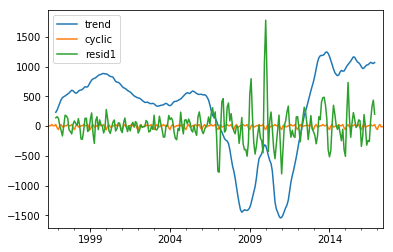

In [142]:
decomposition = seasonal_decompose(ts.diff().dropna())

components = pd.DataFrame()
components['trend']  = decomposition.trend
components['cyclic'] = decomposition.seasonal
components['resid1'] = decomposition.resid

components.plot()

# Tom Augspurger Replication

In [160]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

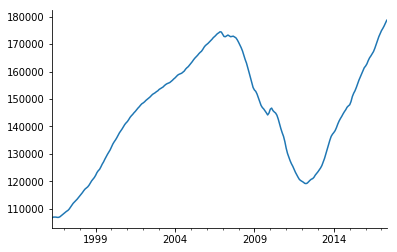

In [154]:
ts.plot()
sns.despine()

In [156]:
y = ts.copy()

In [234]:
X = pd.concat([y.shift(i) for i in range(6)], axis=1,keys = ['L%s'%i for i in range(6)])
X['y'] = y.shift(-6)
X = X.dropna()
X = X.assign(trend=np.arange(len(X)))
X.head()

,L0,L1,L2,L3,L4,L5,y,trend
1996-09-01,106900.0,106900.0,107000.0,107000.0,107000.0,106700.0,109100.0,0
1996-10-01,107100.0,106900.0,106900.0,107000.0,107000.0,107000.0,109400.0,1
1996-11-01,107500.0,107100.0,106900.0,106900.0,107000.0,107000.0,109900.0,2
1996-12-01,107900.0,107500.0,107100.0,106900.0,106900.0,107000.0,110600.0,3
1997-01-01,108300.0,107900.0,107500.0,107100.0,106900.0,106900.0,111300.0,4


In [242]:
mod_lagged = smf.ols('y ~ trend + L0 + L1 + L2 + L3 + L4 + L5', data=X)
res_lagged = mod_lagged.fit()
res_lagged.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     3127.
Date:                Thu, 20 Jul 2017   Prob (F-statistic):          5.39e-228
Time:                        09:35:04   Log-Likelihood:                -2183.5
No. Observations:                 243   AIC:                             4383.
Df Residuals:                     235   BIC:                             4411.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5760.1954    997.396      5.775      0.000    3795.215    7725.176
trend          4.5090      1.920      2.349      0.020       0.727       8.291
L0             5.8054      0.550     10.558      0.000       4.722       6.889
L1            -6.7399      1.360     -4.957      0.000      -9.419      -4.061
L2             4.3553      1.749      2.490      0.013       0.909       7.801
L3            -2.5545      1.748     -1.462      0.145      -5.997       0.888
L4             0.0360      1.355      0.027      0.979      -2.634       2.706
L5             0.0561      0.548      0.102      0.919      -1.024       1.136
==============================================================================
Omnibus:                       57.334   Durbin-Watson:                   0.418
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.931
Skew:                          -1.099   Prob(JB):                     8.27e-30
Kurtosis:                       5.898   Cond. No.                     2.82e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.82e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [245]:
yhat = res_lagged.predict(X[['trend','L0','L1','L2','L3','L4','L5']])

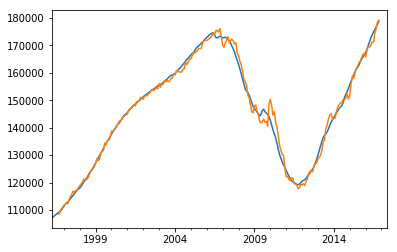

In [248]:
y.shift(-6).plot()
yhat.plot()

In [199]:
temp = pd.Series(index=X.index)

for i in range(X.shape[0]):
    m = temp.index.values[i]
    b = res_lagged.params
    x0 = b['Intercept']
    temp[m] = x0 + b['trend']*X.loc[m,'trend'] + b['L1']*X.loc[m,'L1'] + b['L2']*X.loc[m,'L2'] + b['L3']*X.loc[m,'L3'] + b['L4']*X.loc[m,'L4']+ b['L5']*X.loc[m,'L5']    
    
temp.plot()

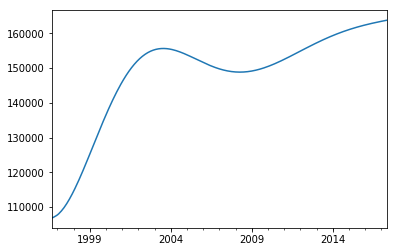

In [228]:
# Walk Forwards
b  = res_lagged.params
x0 = b['Intercept']
# b  = b.drop('Intercept')

temp = pd.DataFrame(index=X.index, columns = X.columns)
temp['trend'] = X['trend']
temp.iloc[0,:] = X.iloc[0,:]
temp['Intercept'] = 1
# temp = temp[b.index.values]  # Put the columns in the same order as the parameters 

m = temp.index.values[0]
 
for i in range(1,temp.shape[0]):
    oldm = m
    m = temp.index.values[i]

    for j in range(2,6):
        temp.loc[m,'L%s'%j] = temp.loc[oldm,'L%s'%(j-1)]
        temp.loc[m,'L1']    = temp.loc[oldm,'y']
    temp.loc[m,'y'] = np.dot(b.values,temp.loc[m,b.index.values].values)
    
temp['y'].plot()

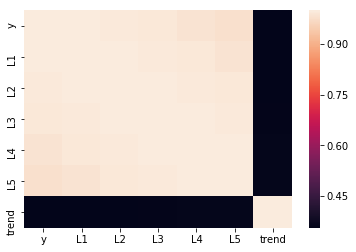

In [191]:
sns.heatmap(X.corr())

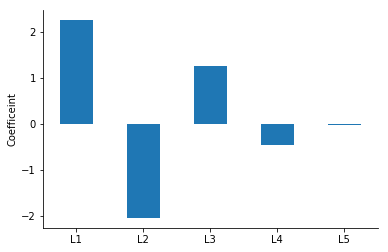

In [176]:
res_lagged.params.drop(['Intercept', 'trend']).plot.bar(rot=0)
plt.ylabel('Coefficeint')
sns.despine()